In [ ]:
from langchain_openai import AzureOpenAIEmbeddings,AzureChatOpenAI
from azure.identity import DefaultAzureCredential,get_bearer_token_provider
from langchain_community.document_loaders import TextLoader, DirectoryLoader
from langchain_chroma import Chroma 
from langchain.text_splitter import RecursiveCharacterTextSplitter
from pydantic import BaseModel,Field
from typing import TypedDict,Annotated,Sequence,Literal
from langchain_core.messages import BaseMessage,HumanMessage
import operator
from langgraph.graph import StateGraph,END,START,MessagesState
from langchain.output_parsers import PydanticOutputParser
from langchain.prompts import PromptTemplate
import os
from dotenv import load_dotenv
from langchain_community.tools import TavilySearchResults,tool
from langchain_experimental.tools import PythonREPLTool
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent


load_dotenv()



os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")  # Update to your API key
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_APIKEY")


token_provider= get_bearer_token_provider(DefaultAzureCredential(), "https://cognitiveservices.azure.com/.default")
model= AzureChatOpenAI(
    api_version="2024-12-01-preview",
    azure_endpoint="https://azopenai-langchain.openai.azure.com/",
    azure_ad_token_provider= token_provider,
    azure_deployment= "gpt-4o-mini"
)


In [ ]:
os.environ

In [ ]:
model.invoke("Hi Team").content

In [ ]:
TavilySearchResults(max_results =1).invoke("latest news please")[0]["title"]

In [ ]:
code ="""
  print("Hello")
"""
PythonREPLTool().invoke(code)

In [ ]:
tavily_tool = TavilySearchResults(max_results =1)

@tool
def python_executor_tool(code:Annotated[str,"The python code to execute to generate your grah"]):
   """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
   try :
       result =PythonREPLTool().invoke(code)
   except BaseException as e:
       return f"failed to execute the code, {e}"
   result_str = f"executed code Successfully, \n output : {result}"
   return result_str

       
          

In [ ]:
python_executor_tool.invoke("x= 10\ny=10\nprint(x+y)")

In [141]:
members=["research_node","coder_node"]
options = members+["FINISH"]
system_prompt = f""""
You are a supervisor, tasked with managing a conversation between the following workers: {members}. 
Given the following user request, respond with the worker to act next. 
Each worker will perform a task and respond with their results and status. 
When finished, respond with FINISH.
"""

class Router(TypedDict):
    next: Literal['research_node', 'coder_node', 'FINISH']

class State(MessagesState):
    next:str

##### Agents

In [135]:
research_agent = create_react_agent(model=model,tools=[tavily_tool],prompt="You are a researcher, Don't do any code execution")
coder_agent = create_react_agent(model=model,tools=[python_executor_tool],prompt="You are a Coder, Don't do any research")

##### Nodes

In [136]:
def  supervisor_node(state: State) -> Command[Literal["research_node","coder_node",END]]:
    messages = [{"role": "system", "content" : system_prompt}] +state["messages"]
    llm_with_structured_output = model.with_structured_output(Router)
    response = llm_with_structured_output.invoke(messages)

    ## next go to node
    goto = response["next"]
    if goto == "FINISH":
        goto= END
    return Command(goto= goto, update ={"next" : goto})    

def research_node(state: State) -> Command[Literal["supervisor_node"]]:
    #this will call research agent
    result = research_agent.invoke(state)
    return Command(goto= "supervisor_node",update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="research_node")
            ]
        })


def coder_node(state: State) -> Command[Literal["supervisor_node"]]:
    result = coder_agent.invoke(state)
    return Command(goto= "supervisor_node",update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder_node")
            ]
        })


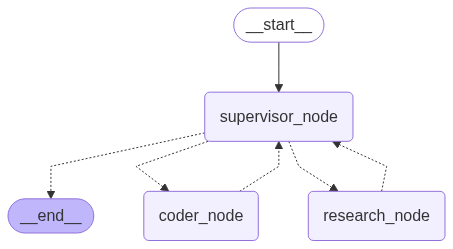

In [137]:
graph = StateGraph(State)
graph.add_node("supervisor_node",supervisor_node)
graph.add_node("research_node",research_node)
graph.add_node("coder_node",coder_node)


graph.add_edge(START, "supervisor_node")
compiledgraph = graph.compile()
compiledgraph

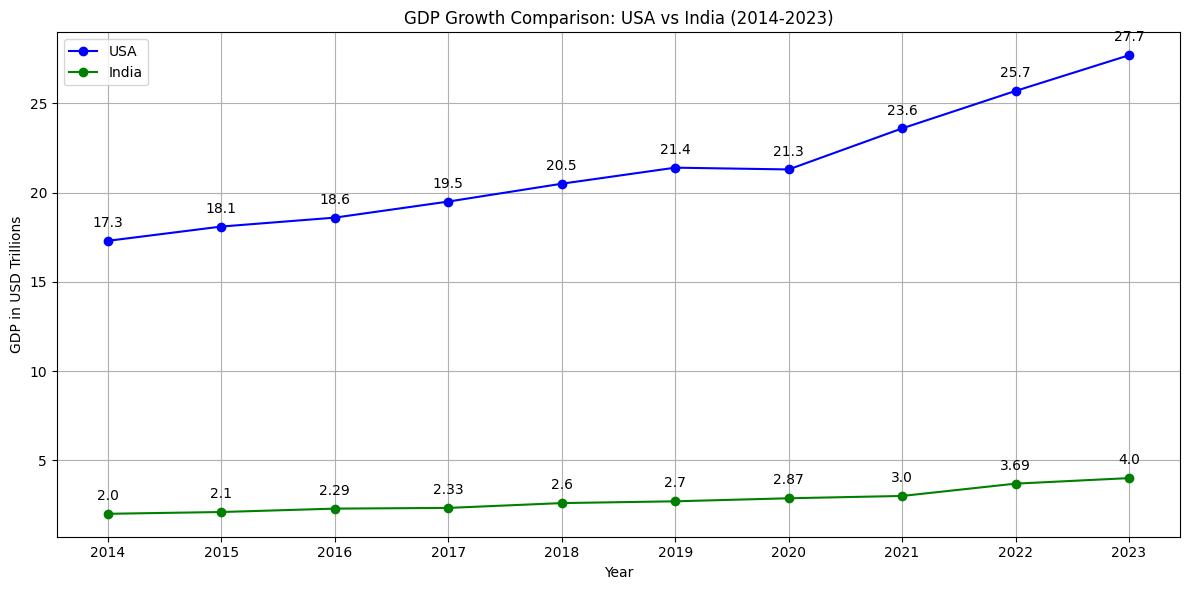

((),
 {'messages': [HumanMessage(content='\nPlease get the GDP data (in USD trillions) for USA and INDIA for the past 10 years. \nThen draw a line chart with two lines one for each country in the same graph. \n\nMake sure to:\n- Label each line with the country name using a legend.\n- Annotate each data point with the actual GDP value.\n- Use proper axes labels and chart title.\n\n', additional_kwargs={}, response_metadata={}, id='c1dd0e97-7835-4cf2-bc4f-80a8e43c45c9'),
   HumanMessage(content="Here's the GDP data summary for the USA and India for the past 10 years, based on the latest available information:\n\n### USA GDP Data (in USD Trillions):\n- 2023: 27.721\n- 2022: 25.744\n- 2021: 23.594\n- 2020: 21.323\n- 2019: (Not explicitly provided, but previous data shows it was archived before indicating a downward adjustment)\n- 2018: (Not explicitly provided, need to derive data)\n- 2017: (Not explicitly provided, need to derive data)\n- 2016: (Not explicitly provided, need to derive da

In [138]:
compiledgraph.invoke(
{"messages": [("user", """
Please get the GDP data (in USD trillions) for USA and INDIA for the past 10 years. 
Then draw a line chart with two lines one for each country in the same graph. 

Make sure to:
- Label each line with the country name using a legend.
- Annotate each data point with the actual GDP value.
- Use proper axes labels and chart title.

""")]},subgraphs=True

)

In [ ]:
events = compiledgraph.stream(
{"messages": [("user", """ What is the the square root of 46""")]},subgraphs=True

)

for s in events:
   print(s)
   print("\n")

GraphRecursionError: Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT

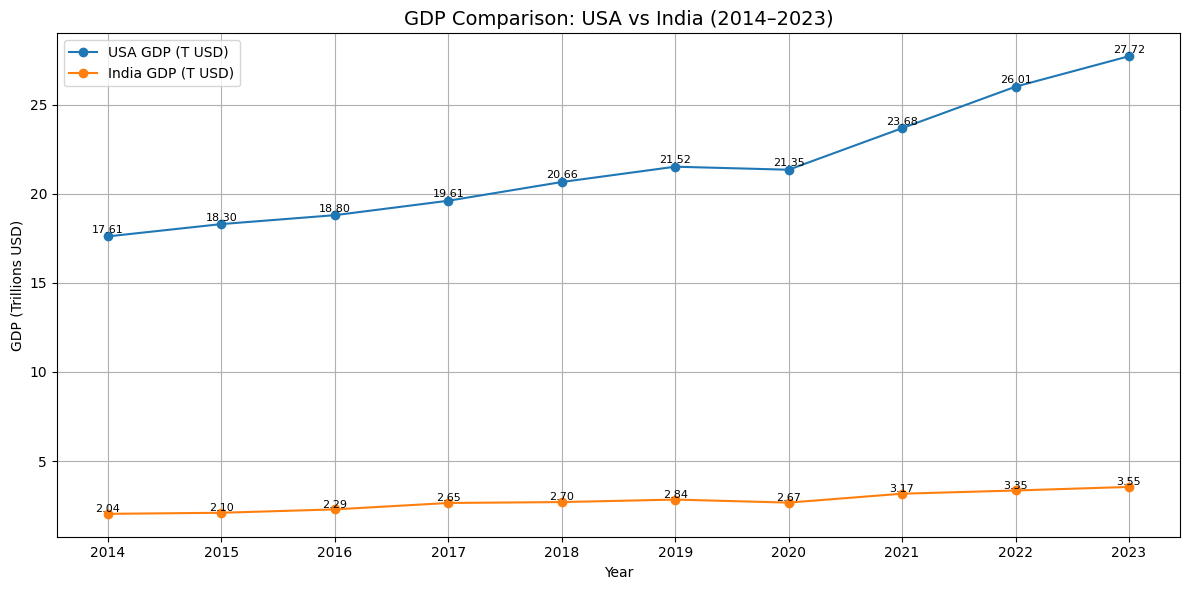

In [122]:
import matplotlib.pyplot as plt

# GDP Data
years = list(range(2014, 2024))
usa_gdp = [17.61, 18.30, 18.80, 19.61, 20.66, 21.52, 21.35, 23.68, 26.01, 27.72]
india_gdp = [2.04, 2.10, 2.29, 2.65, 2.70, 2.84, 2.67, 3.17, 3.35, 3.55]

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(years, usa_gdp, marker='o', label='USA GDP (T USD)')
plt.plot(years, india_gdp, marker='o', label='India GDP (T USD)')

# Add data labels
for x, y in zip(years, usa_gdp):
    plt.text(x, y + 0.2, f"{y:.2f}", ha='center', fontsize=8)

for x, y in zip(years, india_gdp):
    plt.text(x, y + 0.1, f"{y:.2f}", ha='center', fontsize=8)

# Formatting
plt.title('GDP Comparison: USA vs India (2014–2023)', fontsize=14)
plt.xlabel('Year')
plt.ylabel('GDP (Trillions USD)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(years)
plt.show()
